In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [13]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
mnist_digits.shape

(70000, 28, 28, 1)

In [31]:
x_data = np.load('data/x_data_5000.npy')
x_data.shape

(50000, 108, 88, 3)

In [57]:
latent_dim = 2

encoder_inputs = keras.Input(shape=x_data.shape[1:])
x = layers.Conv2D(8, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(x)

x = layers.Flatten()(x)
x = layers.Dense(516, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(27 * 22 * 16, activation="relu")(latent_inputs)
x = layers.Reshape((27, 22, 16))(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(8, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3,  activation="sigmoid", padding="same")(x)


encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_78 (InputLayer)           [(None, 108, 88, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_103 (Conv2D)             (None, 54, 44, 8)    224         input_78[0][0]                   
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 27, 22, 16)   1168        conv2d_103[0][0]                 
__________________________________________________________________________________________________
flatten_38 (Flatten)            (None, 9504)         0           conv2d_104[0][0]                 
____________________________________________________________________________________________

In [58]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [79]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_data, epochs=10000, batch_size=256)

Epoch 1/10000
  2/196 [..............................] - ETA: 33s - loss: 519.9464 - reconstruction_loss: 519.9463 - kl_loss: 1.8145e-04

KeyboardInterrupt: 

In [65]:
x_decoded.shape

(1, 108, 88, 3)

In [75]:
import matplotlib.pyplot as plt


# display a n*n 2D manifold of digits
n = 30
digit_size = 28
scale = 2.0
figsize = 15
figure = np.zeros((108,88,3))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(108*88*3)
        figure[
            i * 108 : (i + 1) * 108,
            j * 108 : (j + 1) * 88,
        ] = digit

plt.figure(figsize=(figsize, figsize))
start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap="Greys_r")
plt.show()


ValueError: could not broadcast input array from shape (28512) into shape (108,88,3)

In [78]:
108*88*3


28512

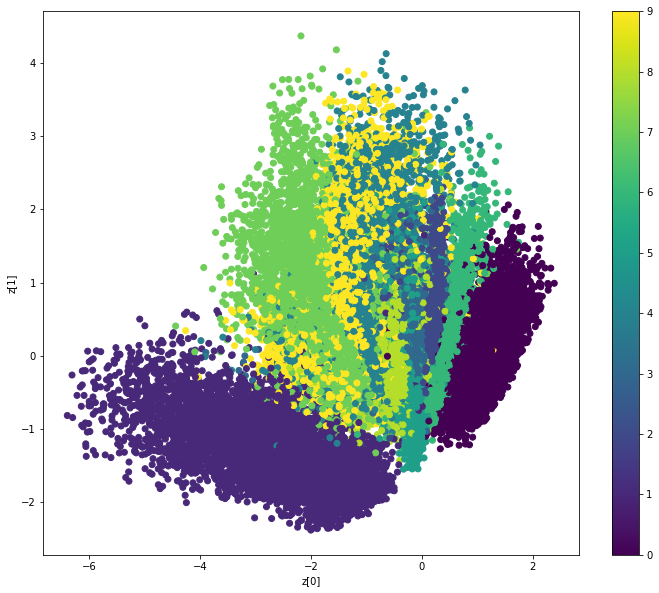

In [10]:
def plot_label_clusters(encoder, decoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, decoder, x_train, y_train)
